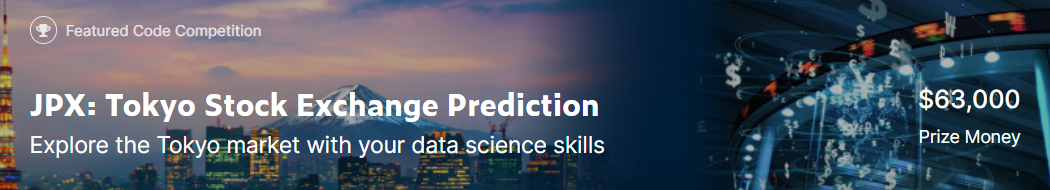

# Who is the host?
**Japan Exchange Group, Inc. (JPX)** is a holding company operating one of the largest stock exchanges in the world, Tokyo Stock Exchange (TSE), and derivatives exchanges Osaka Exchange (OSE) and Tokyo Commodity Exchange (TOCOM). JPX is hosting this competition and is supported by AI technology company **AlpacaJapan Co.,Ltd**.

# What is this competition?

This competition will compare your models against real future returns after the training phase is complete. The competition will involve **building portfolios from the stocks eligible for predictions (around 2,000 stocks)**. Specifically, each participant ranks the stocks from highest to lowest expected returns and is **evaluated on the difference in returns between the top and bottom 200 stocks**. You'll have access to financial data from the Japanese market, such as stock information and historical stock prices to train and test your model.

**All winning models will be made public** so that other participants can learn from the outstanding models. Excellent models also may increase the interest in the market among retail investors, including those who want to practice quantitative trading. At the same time, you'll gain your own insights into programmatic investment methods and portfolio analysis―and you may even discover you have an affinity for the Japanese market.

# What is the evaluation metric?

- [Sharpe ratio](https://en.wikipedia.org/wiki/Sharpe_ratio)

Its python implementation is kindly shared by the host:

[JPX Competition Metric Definition](https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition)

# How to submit?
You must submit to this competition using the provided python **time-series API**, which ensures that models do not peek forward in time. To use the API, follow this template in Kaggle Notebooks.

You will get an error if you:

- Use ranks that are below zero or greater than or equal to the number of stocks for a given date.
- Submit any duplicated ranks.
- Change the order of the rows.

Submissions to this competition must be made through Notebooks. In order for the "Submit" button to be active after a commit, the following conditions must be met:

- CPU Notebook <= 9 hours run-time
- GPU Notebook <= 9 hours run-time
- Internet access disabled
- Freely & publicly available external data is allowed, including pre-trained models

Submission file must be named **submission.csv**. The API will generate this submission file for you.

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import requests
import json
import gc
import math
import random
import pathlib
import glob
import joblib
import time
import datetime
import pytz
from collections import defaultdict
from tqdm.auto import tqdm
from decimal import ROUND_HALF_UP, Decimal
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from multiprocessing import Pool, cpu_count
from dateutil.relativedelta import relativedelta, FR

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

sns.set_context("talk")
style.use('seaborn-colorblind')

pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

# Check machine spec

In [ ]:
# check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Config

In [ ]:
DEBUG = False
BASE_DIR = '../input/jpx-tokyo-stock-exchange-prediction'
EXPERIMENT_NAME = '0001'
OUTPUT_DIR = './'

In [ ]:
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

today = datetime.datetime.now().strftime('%Y-%m-%d')
logger = init_logger(log_file=os.path.join(OUTPUT_DIR, f'{today}.log'))
logger.info('Start Logging...')

# Utils

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

# Load data

This dataset contains historic data for a variety of Japanese stocks and options. Your challenge is to predict the future returns of the stocks.

As historic stock prices are not confidential this will be a forecasting competition using the time series API. **The data for the public leaderboard period is included as part of the competition dataset. Expect to see many people submitting perfect submissions for fun. Accordingly, the active phase public leaderboard for this competition is intended as a convenience for anyone who wants to test their code**. The forecasting phase leaderboard will be determined using real market data gathered after the submission period closes.


## Folders

data_specifications/ - Definitions for individual columns.

jpx_tokyo_market_prediction/ Files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory.

Copies of data files exist in multiple folders that cover different time windows and serve different purposes.

train_files/ Data folder covering the main training period.

supplemental_files/ Data folder containing a dynamic window of supplemental training data. This will be updated with new data during the main phase of the competition in early May, early June, and roughly a week before the submissions are locked.

example_test_files/ Data folder covering the public test period. Intended to facilitate offline testing. Includes the same columns delivered by the API (ie no Target column). You can calculate the Target column from the Close column; it's the return from buying a stock the next day and selling the day after that. This folder also includes an example of the sample submission file that will be delivered by the API.

## Files
*/stock_prices.csv The core file of interest. Includes the daily closing price for each stock and the target column.

In [ ]:
FOLDER = 'train_files'
# FOLDER = 'supplemental_files'

In [ ]:
stock_prices = pd.read_csv(os.path.join(BASE_DIR, FOLDER, 'stock_prices.csv')).pipe(reduce_mem_usage)

print(stock_prices.shape)
stock_prices.head()

*/options.csv Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly.

In [ ]:
options = pd.read_csv(os.path.join(BASE_DIR, FOLDER, 'options.csv')).pipe(reduce_mem_usage)

print(options.shape)
options.head()

*/secondary_stock_prices.csv The core dataset contains on the 2,000 most commonly traded equities but many less liquid securities are also traded on the Tokyo market. This file contains data for those securities, which aren't scored but may be of interest for assessing the market as a whole.

In [ ]:
secondary_stock_prices = pd.read_csv(os.path.join(BASE_DIR, FOLDER, 'secondary_stock_prices.csv')).pipe(reduce_mem_usage)

print(secondary_stock_prices.shape)
secondary_stock_prices.head()

*/trades.csv Aggregated summary of trading volumes from the previous business week.



In [ ]:
trades = pd.read_csv(os.path.join(BASE_DIR, FOLDER, 'trades.csv')).pipe(reduce_mem_usage)

print(trades.shape)
trades.head()

*/financials.csv Results from quarterly earnings reports.



In [ ]:
financials = pd.read_csv(os.path.join(BASE_DIR, FOLDER, 'financials.csv')).pipe(reduce_mem_usage)

print(financials.shape)
financials.head()

stock_list.csv - Mapping between the SecuritiesCode and company names, plus general information about which industry the company is in.


In [ ]:
stock_list = pd.read_csv(os.path.join(BASE_DIR, 'stock_list.csv')).pipe(reduce_mem_usage)

print(stock_list.shape)
stock_list.head()

# EDA

Let's have a look at some of the data.

## Candlestick chart
What's your favorite Japanese company? 

I can tell you. It's Nintendo, right? 

Yeah, I get that. No one hates nintendo. So let's have a look its chart (historical price change).

In [ ]:
code = 7974 # nintendo

def plot_chart(stock_prices, code=7974):
    fig = go.Figure(data=[go.Candlestick(x=stock_prices.query('SecuritiesCode == @code')['Date'],
                    open=stock_prices.query('SecuritiesCode == @code')['Open'],
                    high=stock_prices.query('SecuritiesCode == @code')['High'],
                    low=stock_prices.query('SecuritiesCode == @code')['Low'],
                    close=stock_prices.query('SecuritiesCode == @code')['Close'])])
    fig.show()
    
plot_chart(stock_prices, code)

You are doing great, nintendo. Without any modeling, I guess I can say you are going higher (probably).

## Target distribution

Our target is daily return. How does it look like?

In [ ]:
stock_prices.tail()

In [ ]:
day = stock_prices['Date'].values[-1] # last day in the training data
fig = px.histogram(stock_prices.query('Date == @day'), x="Target")
fig.show()

OK, there look almost normally distributed, but there are some high-return (right end) and low-return (left end) outliers. 

Which company are they? I want to long or short them:D

In [ ]:
# very high return
stock_list.loc[stock_list['SecuritiesCode'].isin(stock_prices.query('Date == @day and Target > 0.18')['SecuritiesCode'])]

Honestly I don't know them but good job!

In [ ]:
# very low return
stock_list.loc[stock_list['SecuritiesCode'].isin(stock_prices.query('Date == @day and Target < -0.18')['SecuritiesCode'])]

I am sorry for Kansai super market. I make sure going to you when I will be in Kansai district next time.

# Feature engineering

There is a wonderful [Train demo](https://www.kaggle.com/code/smeitoma/train-demo), kindly shared by the host. I would stick to their code such that I am on the safe side.

I modified their code a bit to my taste:

- introducing RSI as a new feature
- multiprocessing for feature engineering

In [ ]:
def adjust_price(price):
    """
    We will generate AdjustedClose using AdjustmentFactor value. 
    This should reduce historical price gap caused by split/reverse-split.
    
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

# adjust close
stock_prices = adjust_price(stock_prices)

In [ ]:
# technical indicators
def RSI(close: pd.DataFrame, period: int = 14) -> pd.Series:
    # https://gist.github.com/jmoz/1f93b264650376131ed65875782df386
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = close.diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return pd.Series(100 - (100 / (1 + RS)))

def get_features_for_predict(code, price=stock_prices):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # prep
    close_col = "AdjustedClose"
    feats = price.loc[price["SecuritiesCode"] == code, ["SecuritiesCode", close_col]].copy()
    
    # feature engineering
    for period in [10, 21, 63]:
        # return features
        feats[f"feature_return_{period}days"] = feats[close_col].pct_change(period)
        
        # historical volatility
        feats[f"feature_volatility_{period}days"] = (
            np.log(feats[close_col]).diff().rolling(period).std()
        )
        
        # difference to moving-average
        feats[f"feature_MAgap_{period}days"] = feats[close_col].rolling(period).mean() / feats[close_col]
        
        # RSI
        feats[f"feature_RSI_{period}days"] = RSI(feats[close_col], period)

    # filling data for nan and inf
    feats = feats.fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)
    
#     # drop AdjustedClose column
#     feats = feats.drop([close_col], axis=1)

    return feats

def add_features(df, code_col='SecuritiesCode'):    
    # FE with multiprocessing (prices)
    tickers = df[code_col].unique().tolist()
    print('FE for {:,} stocks...'.format(len(tickers)))
    start_time = time.time()
    with Pool(cpu_count()) as p:
        feature_dfs = list(tqdm(p.imap(get_features_for_predict, tickers), total=len(tickers)))
    return pd.concat(feature_dfs)

In [ ]:
# feature engineering
feature_df = add_features(stock_prices, code_col='SecuritiesCode')

print(feature_df.shape)
feature_df.head()

# Train tset split

Again, we use what the host offered to us. Imitation as inspiration, you know?

In [ ]:
# split data into TRAIN and TEST
TRAIN_END = "2019-12-31"
# We put a week gap between TRAIN_END and TEST_START
# to avoid leakage of test data information from label
TEST_START = "2020-01-06"

In [ ]:
def get_label(price, code):
    """ Labelizer
    Args:
        price (pd.DataFrame): dataframe of stock_price.csv
        code (int): Local Code in the universe
    Returns:
        df (pd.DataFrame): label data
    """
    df = price.loc[price["SecuritiesCode"] == code].copy()
    df.loc[:, "label"] = df["Target"]

    return df.loc[:, ["SecuritiesCode", "label"]]

def get_features_and_label(price, codes, features):
    """
    Args:
        price (pd.DataFrame): loaded price data
        codes  (array) : target codes
        feature (pd.DataFrame): features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

    # generate feature one by one
    for code in tqdm(codes):

        feats = features[features["SecuritiesCode"] == code].dropna()
        labels = get_label(price, code).dropna()

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]

            assert (labels.loc[:, "SecuritiesCode"] == feats.loc[:, "SecuritiesCode"]).all()
            labels = labels.loc[:, "label"]

            # split data into TRAIN and TEST
            _train_X = feats[: TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[: TRAIN_END]
            _test_y = labels[TEST_START:]
            
            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)

            # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)
            
    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y

In [ ]:
# fetch prediction target SecuritiesCodes
codes = sorted(stock_prices["SecuritiesCode"].unique())

# train test split
train_X, train_y, test_X, test_y = get_features_and_label(
    stock_prices, codes, feature_df
)

# Modeling

Again we use what the host offered to us. Always nice to start with something simple such as LGB.

In [ ]:
# features to use
feat_cols = [f for f in train_X.columns if f.startswith('feature_')]
logger.info(len(feat_cols))
logger.info(feat_cols)

In [ ]:
lgbm_params = {
    'n_estimators': 10000,
    'num_leaves': 2 ** 4 + 1,
    'objective': 'huber',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'max_depth': 4,
    'learning_rate': 0.01,
    'feature_fraction': 0.4,
    'lambda_l1': 0.1,
    'lambda_l2': 1,
    'seed': 46,
    'early_stopping_rounds': 100,
}    
# initialize model
pred_model = lgb.LGBMRegressor(**lgbm_params)

# train
pred_model.fit(
    train_X[feat_cols], train_y
    , eval_set=[(test_X[feat_cols], test_y)]
    , verbose=10
)

# save
pred_model.booster_.save_model(os.path.join(OUTPUT_DIR, "model.txt"))

# prepare result data
result = test_X[["SecuritiesCode"]].copy()

# predict
result.loc[:, "predict"] = pred_model.predict(test_X[feat_cols])

# actual result
result.loc[:, "Target"] = test_y.values

def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("predict", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df["predict"]))
    return df

result = result.sort_values(["Date", "predict"], ascending=[True, False])
result = result.groupby("Date").apply(set_rank)

In [ ]:
# feature importance
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = feat_cols
feature_importance_df['importance'] = pred_model.booster_.feature_importance(importance_type="gain")

sns.barplot(x='importance', y='features', data=feature_importance_df.sort_values(by=['importance'], ascending=False))

Oh previous return is apparently very predictive to the future return.

# Validation score

How good is our model? Give me a hope to be rich.

In [ ]:
# calc spread return sharpe
logger.info('validation sharpe = {:.4f}'.format(calc_spread_return_sharpe(result, portfolio_size=200)))

How dare you my model.

Apparently there is a huge room to be improved. Let's aim for sharpe = 2.0!

There is a saying regarding hedge funds, which goes like 

>If you have sharpe = 2, you don't need a marketing department.

In [ ]:
# we will show daily spread return of the model.
df_result = result.groupby('Date').apply(_calc_spread_return_per_day, 200, 2)
df_result.plot(figsize=(20, 8))

In [ ]:
# a cumulative spread return of the mode
df_result.cumsum().plot(figsize=(20, 8))

Oh does this growing profit curve mean my model can make profit with Japanese stocks? Would be nice

# Submit

In [ ]:
# prep
price_cols = [
    "Date",
    "SecuritiesCode",
    "Close",
    "AdjustmentFactor",
]

stock_prices = stock_prices.reset_index()[price_cols]
stock_prices = stock_prices.loc[stock_prices["Date"] >= "2021-08-01"]
stock_prices.sort_values(by=['Date', 'SecuritiesCode'], inplace=True)
stock_prices.reset_index(drop=True, inplace=True)
stock_prices.tail(2)

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:

counter = 0
# fetch data day by day
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    current_date = prices["Date"].iloc[0]
    sample_prediction_date = sample_prediction["Date"].iloc[0]
    print(f"current_date: {current_date}, sample_prediction_date: {sample_prediction_date}")

    if counter == 0:
        # to avoid data leakage
        df_price_raw = stock_prices.loc[stock_prices["Date"] < current_date]

    # filter data to reduce culculation cost
    threshold = (pd.Timestamp(current_date) - pd.offsets.BDay(80)).strftime("%Y-%m-%d")
    print(f"threshold: {threshold}")
    df_price_raw = df_price_raw.loc[df_price_raw["Date"] >= threshold]

    # to generate AdjustedClose, increment price data
    df_price_raw = pd.concat([df_price_raw, prices[price_cols]])
    # generate AdjustedClose
    df_price = adjust_price(df_price_raw)

    # get target SecuritiesCodes
    codes = sorted(prices["SecuritiesCode"].unique())

    # generate feature
    feature = pd.concat([get_features_for_predict(code, df_price) for code in codes])
    # filter feature for this iteration
    feature = feature.loc[feature.index == current_date]

    # prediction
    feature.loc[:, "predict"] = pred_model.predict(feature[feat_cols])

    # set rank by predict
    feature = feature.sort_values("predict", ascending=False).drop_duplicates(subset=['SecuritiesCode'])
    feature.loc[:, "Rank"] = np.arange(len(feature))
    feature_map = feature.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(feature_map)

    # check Rank
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1

    # register your predictions
    env.predict(sample_prediction)
    counter += 1

In [ ]:
! head submission.csv

ALL DONE!

There are plenty of things to explore the data further. I hope this notebook helps some to get started in this competition. That said...

**DON'T SIMPLY COPY THIS NOTEBOOK AND PUBLISH WITH MINOR CHANGE!**

**DON'T PUBLISH THIS NOTEBOOK IN ANOTHER LANGUAGE (JAPANESE etc)!.**

If you want to share your ideas using this notebook, please cite. Thank you.